## Analysis of Unrestrained Fully Coupled Trajectory to Generate Parameters for Restraints

### Get Ligand Heavy Atoms. Find Potential Anchor Points for Each

Traj with thetaB ~ 2.6 taken from restrain lambda = 0.000 run 5  ~/Documents/research/restraint_comparison_mif/study/bound/boresch_l1_11_p1_4946

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis.distances import dist
from MDAnalysis.lib.distances import calc_dihedrals
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import nglview as nv

u = mda.Universe("../../input_unrestrained/SYSTEM.top", "traj000000001_thetaB_26.dcd")

lig_heavy = u.select_atoms("resname LIG and not name H*")

# anchors dict of dict. For each ligand heavy atom there is a dictionary of protein heavy atoms,
# for each of which there is a dictionary of average distance and standard deviation

anchors_dict = {}
for lig_atom in lig_heavy:
    for prot_atom in u.select_atoms(f"(protein or resname PRT) and (around 10 index {lig_atom.index}) and (not name H*)"): # protein does not recognise PRT
        anchors_dict[(lig_atom.index,prot_atom.index)]={}
        anchors_dict[(lig_atom.index, prot_atom.index)]["dists"]=[]
    

/home/finlayclark/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/home/finlayclark/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


### Compute Average Distance and SD


In [2]:
for frame in u.trajectory:
    for lig_atom_index, prot_atom_index in anchors_dict.keys():
        distance = dist(mda.AtomGroup([u.atoms[lig_atom_index]]), mda.AtomGroup([u.atoms[prot_atom_index]]), box=frame.dimensions)[2][0]
        anchors_dict[(lig_atom_index,prot_atom_index)]["dists"].append(distance)

In [3]:
# change lists to numpy arrays
for pair in anchors_dict.keys():
    anchors_dict[pair]["dists"] = np.array(anchors_dict[pair]["dists"])

In [4]:
# calculate average and SD
for pair in anchors_dict.keys():
    anchors_dict[pair]["avg_dist"] = anchors_dict[pair]["dists"].mean()
    anchors_dict[pair]["sd_dist"] = anchors_dict[pair]["dists"].std()

In [5]:
# get n pairs with lowest SD
pairs_ordered_sd=[]
for item in sorted(anchors_dict.items(), key=lambda item: item[1]["sd_dist"]):
    pairs_ordered_sd.append(item[0])
    print(f'Pair: {item[0]}, av distance: {item[1]["avg_dist"]:.2f}, SD: {item[1]["sd_dist"]:.2f}')

Pair: (21, 4950), av distance: 2.74, SD: 0.14
Pair: (2, 4950), av distance: 4.91, SD: 0.16
Pair: (11, 4950), av distance: 3.60, SD: 0.17
Pair: (4, 4950), av distance: 5.96, SD: 0.18
Pair: (4, 4946), av distance: 8.24, SD: 0.19
Pair: (2, 4946), av distance: 7.09, SD: 0.19
Pair: (11, 4946), av distance: 5.87, SD: 0.19
Pair: (4, 4949), av distance: 6.97, SD: 0.19
Pair: (11, 4949), av distance: 4.59, SD: 0.20
Pair: (21, 4946), av distance: 4.79, SD: 0.20
Pair: (11, 935), av distance: 5.01, SD: 0.20
Pair: (11, 931), av distance: 7.32, SD: 0.20
Pair: (10, 4914), av distance: 3.61, SD: 0.20
Pair: (11, 1631), av distance: 4.66, SD: 0.21
Pair: (2, 4949), av distance: 5.87, SD: 0.21
Pair: (5, 4909), av distance: 3.88, SD: 0.21
Pair: (11, 916), av distance: 8.37, SD: 0.21
Pair: (11, 932), av distance: 7.79, SD: 0.21
Pair: (6, 4914), av distance: 4.20, SD: 0.21
Pair: (11, 933), av distance: 6.06, SD: 0.21
Pair: (10, 4912), av distance: 3.73, SD: 0.21
Pair: (4, 4944), av distance: 8.74, SD: 0.21
Pa

In [6]:
# Print out pairs with lowest SD
print("The ligand-protein atom pairs with the lowest SD in distance are:")
for i in range(5):
    print(f"{u.atoms[pairs_ordered_sd[i][0]]} and {u.atoms[pairs_ordered_sd[i][1]]}")


The ligand-protein atom pairs with the lowest SD in distance are:
<Atom 22: OAA of type oh of resname LIG, resid 1 and segid SYSTEM> and <Atom 4951: OD1 of type O of resname ASN, resid 326 and segid SYSTEM>
<Atom 3: CAD of type ca of resname LIG, resid 1 and segid SYSTEM> and <Atom 4951: OD1 of type O of resname ASN, resid 326 and segid SYSTEM>
<Atom 12: CAP of type ca of resname LIG, resid 1 and segid SYSTEM> and <Atom 4951: OD1 of type O of resname ASN, resid 326 and segid SYSTEM>
<Atom 5: CAF of type ca of resname LIG, resid 1 and segid SYSTEM> and <Atom 4951: OD1 of type O of resname ASN, resid 326 and segid SYSTEM>
<Atom 5: CAF of type ca of resname LIG, resid 1 and segid SYSTEM> and <Atom 4947: CB of type 2C of resname ASN, resid 326 and segid SYSTEM>


In [15]:
view3 = nv.show_mdanalysis(u)
#view3.add_representation('licorice', selection="resname LIG", color='orange')
view3.update_representation('licorice', selection='ligand', color='blue')
view3

NGLWidget(max_frame=299)

### For Pairs with Lowest Pairwise RMSDs, find Adjacent Heavy Atoms

In [7]:
def get_anchor_ats(a1_idx,u):
    """Takes in index of anchor atom 1 and universe and returns
    list of all three anchor atoms, which are chosen to be bonded
    and not H"

    Args:
        a1_idx (int): Index of the first anchor atom
        u (mda universe): The mda universe

    Returns:
        ints: The indices of all three anchor points
    """

    a1_at = u.atoms[a1_idx]
    bonded_heavy_at = a1_at.bonded_atoms.select_atoms("not name H*")
    a2_idx = bonded_heavy_at[0].index

    if len(bonded_heavy_at)>1:
        # not at end of chain
        a3_idx = bonded_heavy_at[1].index
        # Might be better to return all possible combinations
    else:
        # at end of chain, get next heavy atom along
        a3_idx = bonded_heavy_at[0].bonded_atoms.select_atoms("not name H*")[1].index
        # Check that we have not just moved back to first atom
        if a3_idx == a1_idx: 
            a3_idx = bonded_heavy_at[0].bonded_atoms.select_atoms("not name H*")[0].index

    return a1_idx, a2_idx, a3_idx

In [8]:
print(get_anchor_ats(pairs_ordered_sd[0][0],u))
print(get_anchor_ats(pairs_ordered_sd[0][1],u))

(21, 11, 2)
(4950, 4949, 4946)


### Use These As Anchors and Plot Variance of Associated Degrees of Freedom

In [9]:
def get_distance(idx1, idx2, u):
    """ Distance in Angstrom"""
    distance = dist(mda.AtomGroup([u.atoms[idx1]]), mda.AtomGroup([u.atoms[idx2]]), box=u.dimensions)[2][0]
    return distance

In [10]:
def get_angle(idx1, idx2, idx3, u):
    """Angle in rad"""
    C = u.atoms[idx1].position 
    B = u.atoms[idx2].position 
    A = u.atoms[idx3].position 
    BA = A - B
    BC = C - B
    angle = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return angle

In [11]:
def get_dihedral(idx1, idx2, idx3, idx4, u):
    """Dihedral in rad"""
    positions =[u.atoms[idx].position for idx in [idx1,idx2,idx3,idx4]]
    dihedral = calc_dihedrals(positions[0], positions[1], positions[2], positions[3], box = u.dimensions)
    return dihedral



In [12]:
def get_boresch_dof(l1,l2,l3,r1,r2,r3,u):
    """Calculate Boresch degrees of freedom from indices of anchor atoms"""
    # Ordering of connection of anchors is r3,r2,r1,l1,l2,l3
    r = get_distance(r1,l1,u)
    thetaA = get_angle(r2,r1,l1,u)
    thetaB = get_angle(r1,l1,l2,u)
    phiA = get_dihedral(r3,r2,r1,l1,u)
    phiB = get_dihedral(r2,r1,l1,l2,u)
    phiC = get_dihedral(r1,l1,l2,l3,u)
    # Not restrained but distance from coolinearity must be checked
    thetaR = get_angle(r3,r2,r1,u) # Receptor internal angle
    thetaL = get_angle(l1,l2,l3,u) # Ligand internal angle
    return r, thetaA, thetaB, phiA, phiB, phiC, thetaR, thetaL


In [13]:
lig_anchors = get_anchor_ats(pairs_ordered_sd[0][0],u)
prot_anchors = get_anchor_ats(pairs_ordered_sd[0][1],u)
get_boresch_dof(lig_anchors[0],lig_anchors[1],lig_anchors[2],prot_anchors[0],prot_anchors[1],prot_anchors[2],u)

(2.726117160921599,
 2.074501,
 2.0107532,
 -2.173319311367638,
 -1.99517629831698,
 -3.0959784397863177,
 2.1295738,
 2.0382032)

In [14]:
# get values of degrees of freedom for lowest SD pairs across whole trajectory

boresch_dof_dict = {}
for pair in pairs_ordered_sd[:200]:
    boresch_dof_dict[pair]={}
    l1_idx, r1_idx = pair
    _, l2_idx, l3_idx = get_anchor_ats(l1_idx,u)
    _, r2_idx, r3_idx = get_anchor_ats(r1_idx,u)
    boresch_dof_dict[pair]["anchor_ats"]=[l1_idx,l2_idx,l3_idx,r1_idx,r2_idx,r3_idx]

    boresch_dof_list = ["r","thetaA","thetaB","phiA","phiB","phiC","thetaR","thetaL"]

    # Add sub dictionaries for each Boresch degree of freedom
    for dof in boresch_dof_list:
        boresch_dof_dict[pair][dof]={}
        boresch_dof_dict[pair][dof]["values"]=[]

    # Populate these dictionaries with values from trajectory
    n_frames = len(u.trajectory)

    for i, frame in enumerate(u.trajectory):
        r, thetaA, thetaB, phiA, phiB, phiC, thetaR, thetaL = get_boresch_dof(l1_idx,l2_idx,l3_idx,r1_idx,r2_idx,r3_idx,u)
        boresch_dof_dict[pair]["r"]["values"].append(r)
        boresch_dof_dict[pair]["thetaA"]["values"].append(thetaA)
        boresch_dof_dict[pair]["thetaB"]["values"].append(thetaB)
        boresch_dof_dict[pair]["phiA"]["values"].append(phiA)
        boresch_dof_dict[pair]["phiB"]["values"].append(phiB)
        boresch_dof_dict[pair]["phiC"]["values"].append(phiC)
        boresch_dof_dict[pair]["thetaR"]["values"].append(thetaR)
        boresch_dof_dict[pair]["thetaL"]["values"].append(thetaL)

        if i == n_frames-1:
            boresch_dof_dict[pair]["tot_var"]=0
            for dof in boresch_dof_list:
                boresch_dof_dict[pair][dof]["values"]=np.array(boresch_dof_dict[pair][dof]["values"])
                boresch_dof_dict[pair][dof]["avg"]=boresch_dof_dict[pair][dof]["values"].mean()
                # For dihedrals, compute variance and mean based on list of values corrected for periodic boundary at 
                # pi radians, because there is no problem with dihedrals in this region
                if dof[:3] == "phi":
                    avg = boresch_dof_dict[pair][dof]["avg"]

                    # correct variance - fully rigorous
                    corrected_values_sd = []
                    for val in boresch_dof_dict[pair][dof]["values"]:
                        dtheta = abs(val - avg)
                        corrected_values_sd.append(min(dtheta, 2*np.pi-dtheta))
                    corrected_values_sd = np.array(corrected_values_sd) 
                    boresch_dof_dict[pair][dof]["sd"]=corrected_values_sd.std()

                    # Correct mean (will fail if very well split above and below 2pi)
                    # get middle of interval based on current mean
                    corrected_values_avg=[]
                    periodic_bound = avg - np.pi
                    if periodic_bound < -np.pi:
                        periodic_bound+=2*np.pi
                    # shift vals from below periodic bound to above
                    for val in boresch_dof_dict[pair][dof]["values"]:
                        if val < periodic_bound:
                            corrected_values_avg.append(val+2*np.pi)
                        else:
                            corrected_values_avg.append(val)
                    corrected_values_avg = np.array(corrected_values_avg)
                    mean_corrected = corrected_values_avg.mean()
                    #shift mean back to normal range
                    if mean_corrected > np.pi:
                        boresch_dof_dict[pair][dof]["avg"]=mean_corrected-2*np.pi
                    else:
                        boresch_dof_dict[pair][dof]["avg"]=mean_corrected
                        
                else:
                    boresch_dof_dict[pair][dof]["sd"]=boresch_dof_dict[pair][dof]["values"].std()
                # Exclude variance of internal angles as these are not restrained
                if (dof != "thetaR" and dof != "thetaL"):
                    boresch_dof_dict[pair]["tot_var"]+=boresch_dof_dict[pair][dof]["sd"]**2
                # Assume Gaussian distributions and calculate force constants for harmonic potentials
                # so as to reproduce these distributions
                boresch_dof_dict[pair][dof]["k"]=0.593/(boresch_dof_dict[pair][dof]["sd"]**2) # RT at 289 K is 0.593 kcal mol-1


In [15]:
boresch_dof_dict

{(21, 4950): {'anchor_ats': [21, 11, 2, 4950, 4949, 4946],
  'r': {'values': array([2.72611716, 2.61354878, 2.69818858, 2.75805521, 2.76422549,
          2.73800526, 2.66999051, 2.57949744, 2.82924595, 2.74589878,
          2.70248801, 2.96868416, 2.85320153, 2.86242682, 2.80890548,
          2.49594304, 2.78069788, 2.91019738, 2.55120152, 2.67569669,
          2.55486794, 2.94699793, 2.69667001, 2.71812358, 2.62824732,
          2.57777665, 2.7114066 , 2.73912342, 2.8108483 , 2.66869788,
          2.71286051, 3.1369315 , 2.69645048, 2.71264775, 2.87873389,
          2.68791765, 2.69724923, 2.9363746 , 3.00643798, 2.75926781,
          2.80840366, 2.91479209, 2.60852308, 2.76531278, 2.80538272,
          2.80331685, 3.14224914, 2.68867304, 2.56512507, 2.70712272,
          2.78126113, 2.53229656, 2.52417193, 2.74175707, 2.77775486,
          2.57044302, 2.64131159, 2.8320861 , 2.65575738, 2.59190028,
          2.71763154, 2.68675572, 2.68532263, 2.85837672, 2.60270971,
          2.7484

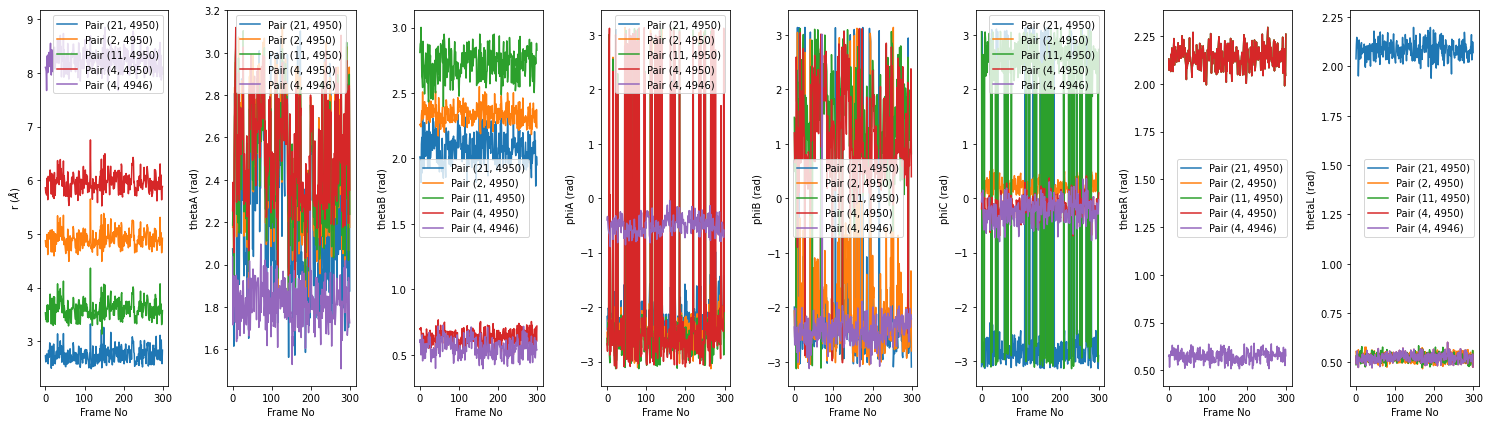

In [16]:
#boresch_dof_list = ["r","thetaA","thetaB","phiA","phiB","phiC","thetaR","thetaL"]
boresch_dof_list = ["r","thetaA","thetaB","phiA","phiB","phiC","thetaR","thetaL"]

# Plot avg and sd of dof for Boresch dof from top 10 lowest SD pairs

num_pairs = 5
n_dof = len(boresch_dof_list)

fig, axs = plt.subplots(1,n_dof, figsize=(2.6*n_dof,6))
for i, dof in enumerate(boresch_dof_list):
    for j, pair in enumerate(boresch_dof_dict.keys()):
        axs[i].plot([x for x in range(300)], boresch_dof_dict[pair][dof]["values"],label=f"Pair {pair}")
        if dof == "r":
            axs[i].set_ylabel("r ($\AA$)")
        else:
            axs[i].set_ylabel(f"{dof} (rad)")
        if j == num_pairs-1:
            break
    axs[i].set_xlabel("Frame No")
    axs[i].legend()
fig.tight_layout()



### Filter, Pick Optimum Degrees of Freedom, and Select Force Constants Based on Variance, Select Equilibrium Values

In [17]:
# Order pairs according to variance 
pairs_ordered_boresch_var=[]
for item in sorted(boresch_dof_dict.items(), key=lambda item: item[1]["tot_var"]):
    pairs_ordered_boresch_var.append(item[0])
    print(f'Pair: {item[0]}, total variance: {boresch_dof_dict[item[0]]["tot_var"]}')

# Filter out r <1, theta >150 or < 30 
selected_pairs_boresch = []
for pair in pairs_ordered_boresch_var:
    cond_dist = boresch_dof_dict[pair]["r"]["avg"] > 1
    avg_angles =[]
    #angles = ["thetaA", "thetaB", "thetaR","thetaL"] # also check internal angles
    angles = ["thetaA", "thetaB"] # May also be good to check internal angles
    for angle in angles:
        avg_angles.append(boresch_dof_dict[pair][angle]["avg"])
    cond_angles = list(map(lambda x: (x<2.62 and x >0.52),avg_angles))
    if cond_dist and all(cond_angles):
        selected_pairs_boresch.append(pair)

print(selected_pairs_boresch)


Pair: (14, 4944), total variance: 0.08062340272563376
Pair: (20, 4944), total variance: 0.08280204756690179
Pair: (4, 4944), total variance: 0.08592185494907857
Pair: (2, 4944), total variance: 0.08622233246239934
Pair: (2, 4925), total variance: 0.08812259289998614
Pair: (14, 4946), total variance: 0.08822379516779161
Pair: (4, 4912), total variance: 0.08876323473211878
Pair: (4, 4925), total variance: 0.0914637263957122
Pair: (20, 4946), total variance: 0.09217294620717437
Pair: (4, 4904), total variance: 0.09292737683909519
Pair: (2, 4946), total variance: 0.09300220832769095
Pair: (2, 4904), total variance: 0.09459866017499234
Pair: (4, 4946), total variance: 0.09630976030947454
Pair: (4, 4910), total variance: 0.0974856088629809
Pair: (11, 935), total variance: 0.09774537506027825
Pair: (4, 4909), total variance: 0.10012705484691097
Pair: (11, 916), total variance: 0.10025734032294369
Pair: (3, 4323), total variance: 0.10113979555757115
Pair: (21, 916), total variance: 0.102829761

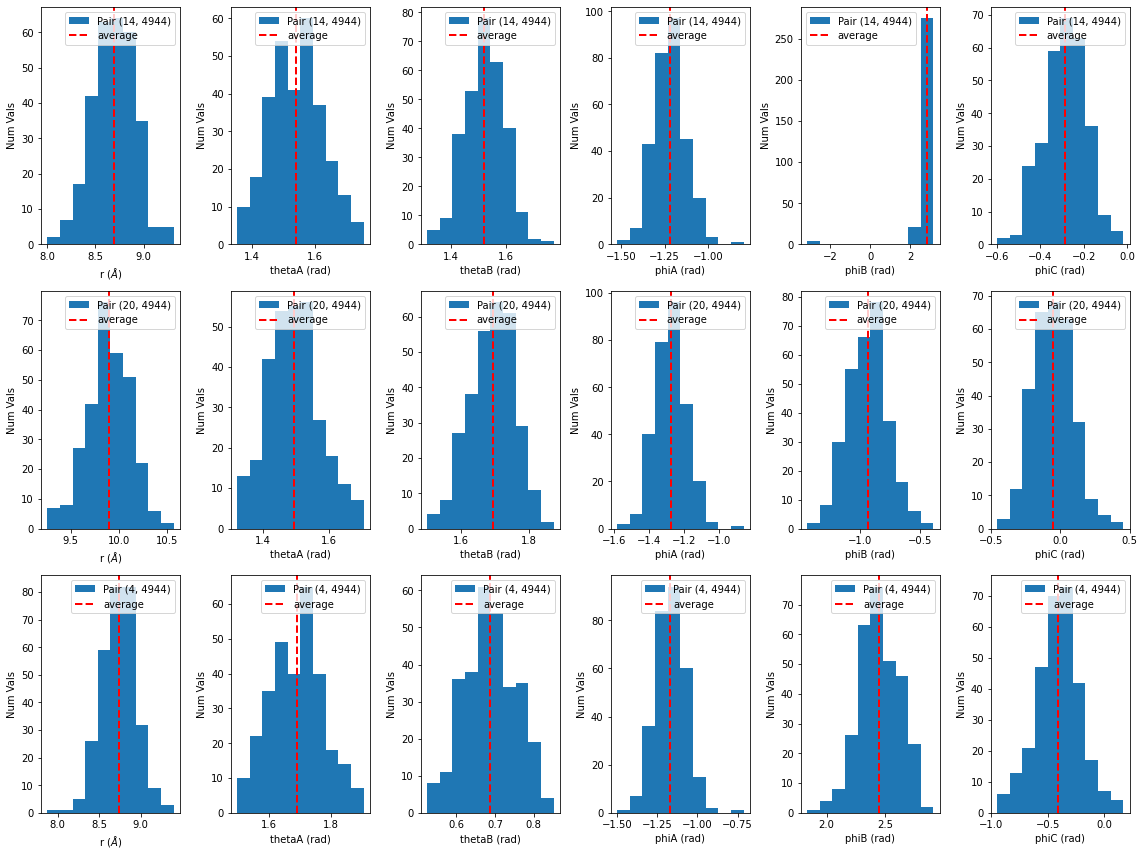

In [18]:
# Plot histograms

fig, axs = plt.subplots(len(selected_pairs_boresch[:3]),6, figsize=(16,4*len(selected_pairs_boresch[:3])))
for pair_idx, pair in enumerate(selected_pairs_boresch[:3]):
    #pair_idx=0
    for i, dof in enumerate(["r","thetaA","thetaB","phiA","phiB","phiC"]):
        axs[pair_idx][i].hist(boresch_dof_dict[pair][dof]["values"],bins=10,label=f"Pair {pair}")
        axs[pair_idx][i].axvline(x=boresch_dof_dict[pair][dof]["avg"], color='r', linestyle='dashed', linewidth=2,label="average")
        if dof == "r":
            axs[pair_idx][i].set_xlabel("r ($\AA$)")
        else:
            axs[pair_idx][i].set_xlabel(f"{dof} (rad)")
        axs[pair_idx][i].set_ylabel("Num Vals")
        axs[pair_idx][i].legend()
fig.tight_layout()


In [19]:
# Print out Boresch parameters

def print_boresch_params(pair):
    l1 = boresch_dof_dict[pair]["anchor_ats"][0]
    l2 = boresch_dof_dict[pair]["anchor_ats"][1]
    l3 = boresch_dof_dict[pair]["anchor_ats"][2]
    r1 = boresch_dof_dict[pair]["anchor_ats"][3]
    r2 = boresch_dof_dict[pair]["anchor_ats"][4]
    r3 = boresch_dof_dict[pair]["anchor_ats"][5]
    r0 = boresch_dof_dict[pair]["r"]["avg"]
    thetaA0 = boresch_dof_dict[pair]["thetaA"]["avg"]
    thetaB0 = boresch_dof_dict[pair]["thetaB"]["avg"]
    phiA0 = boresch_dof_dict[pair]["phiA"]["avg"]
    phiB0 = boresch_dof_dict[pair]["phiB"]["avg"]
    phiC0 = boresch_dof_dict[pair]["phiC"]["avg"]
    kr = boresch_dof_dict[pair]["r"]["k"]
    kthetaA = boresch_dof_dict[pair]["thetaA"]["k"]
    kthetaB = boresch_dof_dict[pair]["thetaB"]["k"]
    kphiA = boresch_dof_dict[pair]["phiA"]["k"]
    kphiB = boresch_dof_dict[pair]["phiB"]["k"]
    kphiC = boresch_dof_dict[pair]["phiC"]["k"]

    print(f'{{"anchor_points":{{"r1":{r1}, "r2":{r2}, "r3":{r3}, "l1":{l1}, "l2":{l2}, "l3":{l3}}},\
    "equilibrium_values":{{"r0":{r0:.2f}, "thetaA0":{thetaA0:.2f}, "thetaB0":{thetaB0:.2f},"phiA0":{phiA0:.2f}, "phiB0":{phiB0:.2f}, "phiC0":{phiC0:.2f}}},\
    "force_constants":{{"kr":{kr:.2f}, "kthetaA":{kthetaA:.2f}, "kthetaB":{kthetaB:.2f}, "kphiA":{kphiA:.2f}, "kphiB":{kphiB:.2f}, "kphiC":{kphiC:.2f}}}}}')




In [20]:
print_boresch_params(selected_pairs_boresch[0])

{"anchor_points":{"r1":4944, "r2":4942, "r3":4946, "l1":14, "l2":4, "l3":5},    "equilibrium_values":{"r0":8.69, "thetaA0":1.54, "thetaB0":1.52,"phiA0":-1.22, "phiB0":2.80, "phiC0":-0.29},    "force_constants":{"kr":12.25, "kthetaA":90.22, "kthetaB":115.70, "kphiA":189.91, "kphiB":42.35, "kphiC":174.58}}


In [21]:
print(get_anchor_ats(selected_pairs_boresch[0][0],u))
print(get_anchor_ats(selected_pairs_boresch[0][1],u))


(14, 4, 5)
(4944, 4942, 4946)


In [22]:
selected_pairs_boresch[0]

(14, 4944)